In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from experiments.generative_modelling.estimate_fSDEs import second_order_estimator, estimate_hurst_from_filter

In [2]:
# Specify parameters -dXt = -gXtdt+dBt
ts_length = 256
ts_diff = 1./ts_length
mean_rev = 0.8
# Specify diffusion model parameters
num_diff_steps = 10000
data_shape = (2000, 1)
beta_max = 20
beta_min = 0.0001
sample_eps = 0.0001
end_diff_time = 1.
diff_time_space = np.linspace(sample_eps, end_diff_time, num_diff_steps)


In [3]:
def get_eff_time(diff_time, bmin, bmax):
    return bmin*diff_time + 0.5*(diff_time**2)*(bmax-bmin)
def get_beta(diff_time, bmin,bmax):
    return np.exp(-0.5*get_eff_time(diff_time, bmin, bmax))
def get_sigma(beta):
    return 1.-np.power(beta, 2)
def perfect_score(diff_time, bmin, bmax, ts_step, sample, meanrev, prevpath):
    # Perfect score for INCREMENTS
    beta_diff = get_beta(diff_time=diff_time, bmin=bmin, bmax=bmax)
    sigma_diff = get_sigma(beta=beta_diff)
    gradscore = -np.power(sigma_diff+np.power(beta_diff,2)*ts_step, -1)
    linscore =  sample - beta_diff*ts_step*(-meanrev*prevpath)
    return gradscore*linscore

In [ ]:
incs = np.zeros(shape=(data_shape[0], ts_length+1))
prev_path = incs[:, [0]]
scores = np.zeros(shape=(data_shape[0], ts_length, num_diff_steps))
means = np.zeros(shape = (data_shape[0], ts_length))

for t in tqdm(range(ts_length)):
    sample = np.random.normal(size=data_shape)
    for diff_index in range(num_diff_steps):
        diff_time = diff_time_space[num_diff_steps-1-diff_index]
        score = perfect_score(diff_time=diff_time, bmin=beta_min, bmax=beta_max, ts_step=ts_diff, sample=sample, meanrev=mean_rev, prevpath=prev_path)
        """if diff_index == 3214:
            beta_diff = get_beta(diff_time=diff_time, bmin=beta_min, bmax=beta_max)
            sigma_diff = get_sigma(beta=beta_diff)
            mean_est = np.power(beta_diff*ts_diff,-1)*(sigma_diff+np.power(beta_diff,2)*ts_diff)*score + np.power(beta_diff*ts_diff,-1)*sample
            means_opt[:, [t]] = mean_est"""
        """if diff_index == 100:
            beta_diff = get_beta(diff_time=diff_time, bmin=beta_min, bmax=beta_max)
            sigma_diff = get_sigma(beta=beta_diff)
            mean_est = np.power(beta_diff*ts_diff,-1)*(sigma_diff+np.power(beta_diff,2)*ts_diff)*score + np.power(beta_diff*ts_diff,-1)*sample
            means_low[:, [t]] = mean_est"""
        if diff_index == 9999:
            beta_diff = get_beta(diff_time=diff_time, bmin=beta_min, bmax=beta_max)
            sigma_diff = get_sigma(beta=beta_diff)
            c1 = np.power(beta_diff*ts_diff,-1)*(sigma_diff+np.power(beta_diff,2)*ts_diff)
            c2 = np.power(beta_diff*ts_diff,-1)
            mean_est = c1*score + c2*sample
            #print(np.mean(mean_est), np.mean(c1*score), np.mean(c2*sample))
            #print(np.std(mean_est), np.std(c1*score), np.std(c2*sample))
            means[:, [t]] = mean_est
        discrete_beta = get_beta(diff_time=diff_time, bmin=beta_min, bmax=beta_max)/num_diff_steps
        drift = sample + 0.5 * discrete_beta * sample + discrete_beta * score
        diffusion = np.sqrt(1.-discrete_beta)
        sample = drift + diffusion*np.random.normal(size=data_shape)
        scores[:, [t], [diff_index]] = score
    incs[:, [t+1]] = sample
    prev_path = np.sum(incs, axis=1)[:, np.newaxis]
    assert(prev_path.shape == data_shape)
incs = incs[:, 1:]
paths = np.cumsum(incs,axis=1)

 11%|█         | 27/256 [00:34<05:07,  1.34s/it]

In [7]:
if len(paths.shape) == 3:
    paths = paths[:,:,0]
time_space = np.linspace((1. / ts_length), 1., num=ts_length)

In [8]:
# Construct estimator for mean reversion
def mean_rev_estimate_plot(paths):
    augdata = np.concatenate([np.zeros(shape=(paths.shape[0], 1)), paths], axis=1)
    denom = np.sum(np.power(augdata[:, :-1], 2), axis=1) * (1. / ts_length)
    diffs = np.diff(augdata, n=1, axis=1)
    num = np.sum(augdata[:, :-1] * diffs, axis=1)
    estimators = -num / denom
    plt.hist(estimators, bins=150, density=True)
    plt.vlines(x=mean_rev, ymin=0, ymax=0.25, label="", color='b')
    plt.title("Estimator")
    plt.legend()
    plt.show()
    plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Python(72488) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


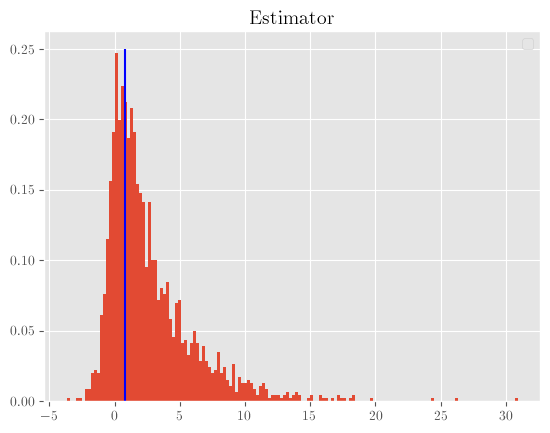

In [9]:
mean_rev_estimate_plot(paths=paths)

In [ ]:
for _ in range(paths.shape[0]):
    plt.plot(np.linspace(0, 1, ts_length), paths[_, :])
plt.show()
plt.close()
#Estimate Hurst indices from paths
U_a1, U_a2 = second_order_estimator(paths=paths, Nsamples=paths.shape[0])
estimate_hurst_from_filter(Ua1=U_a1, Ua2=U_a2, epoch=0).flatten()

In [16]:
def means_lin_reg(means, paths, type):
    N = means.shape[1]
    mean_revs = []
    for pathidx in tqdm(range(data_shape[0])):
        ys = means[pathidx, :].flatten().reshape((N, 1))
        designmat = paths[pathidx, :-1].flatten().reshape((N, 1))
        meanrev = -np.linalg.solve(designmat.T @ designmat, designmat.T @ ys)
        mean_revs.append(float(meanrev))
    plt.hist(mean_revs, bins=150, density=True)
    print(mean_revs)
    plt.xlim((-2, 2))
    plt.title(f"Mean Rev LinReg  for {type} with mean {np.mean(mean_revs)} std {np.std(mean_revs)}")
    plt.show()
    plt.close()

100%|██████████| 2000/2000 [00:00<00:00, 46522.22it/s]
/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


[0.7999999999999997, 0.7999999999999999, 0.8, 0.7999999999999997, 0.8, 0.7999999999999999, 0.8000000000000002, 0.8, 0.8, 0.8000000000000009, 0.8000000000000009, 0.7999999999999997, 0.8, 0.7999999999999993, 0.7999999999999993, 0.8, 0.7999999999999998, 0.8, 0.8, 0.7999999999999998, 0.8000000000000004, 0.8000000000000002, 0.8, 0.8000000000000004, 0.8000000000000002, 0.8, 0.8, 0.8000000000000006, 0.8000000000000007, 0.8000000000000004, 0.7999999999999999, 0.8000000000000009, 0.7999999999999992, 0.8000000000000005, 0.7999999999999997, 0.8000000000000009, 0.7999999999999995, 0.7999999999999998, 0.7999999999999997, 0.8000000000000002, 0.8000000000000004, 0.7999999999999996, 0.8000000000000005, 0.8000000000000006, 0.8000000000000009, 0.8, 0.7999999999999999, 0.8000000000000004, 0.8000000000000002, 0.7999999999999999, 0.8000000000000006, 0.7999999999999993, 0.8000000000000002, 0.7999999999999996, 0.7999999999999996, 0.800000000000001, 0.8000000000000006, 0.7999999999999995, 0.7999999999999999, 

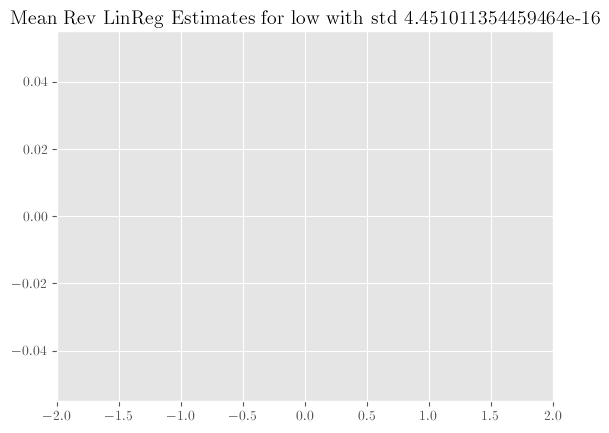

In [17]:
#means_lin_reg(means_low[:, 1:], paths, "low")
#means_lin_reg(means_opt[:, 1:], paths, "opt")
means_lin_reg(means[:, 1:], paths, "low")

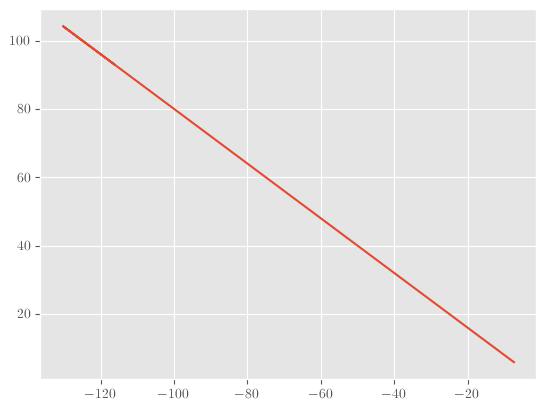

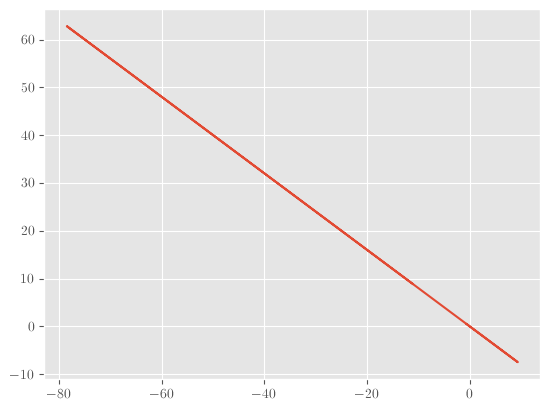

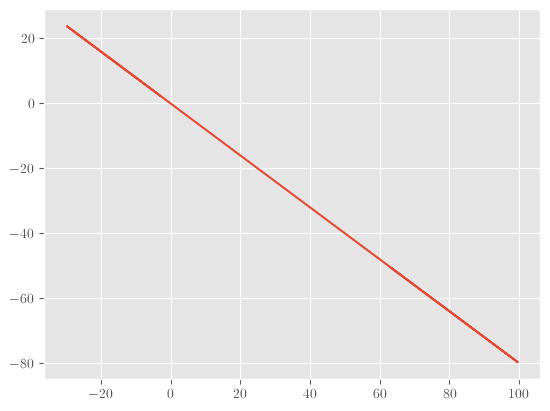

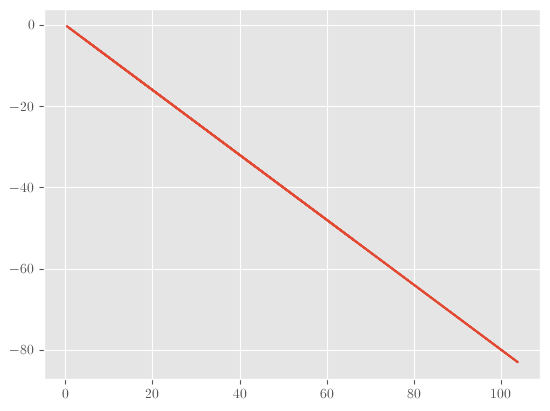

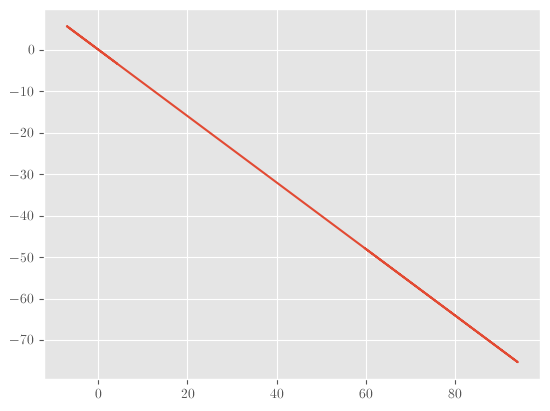

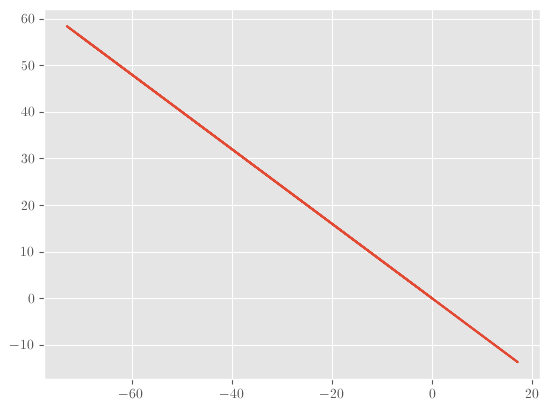

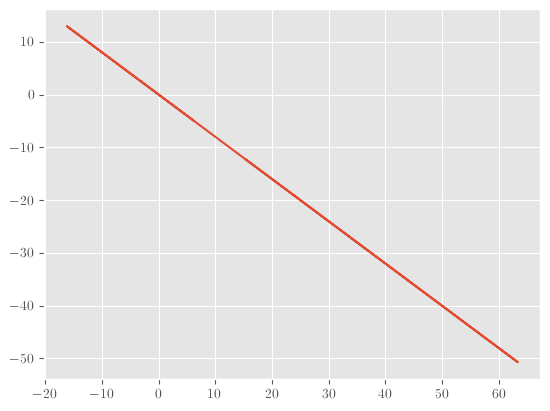

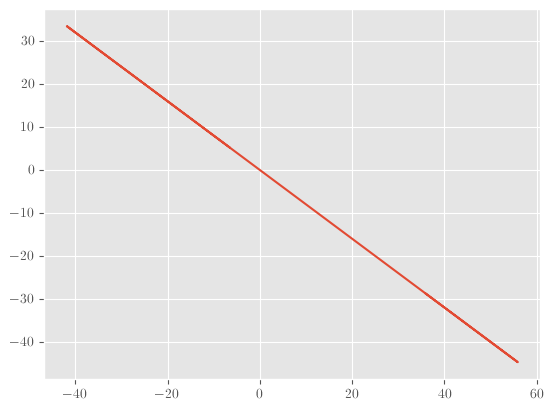

KeyboardInterrupt: 

In [12]:
for idx in range(data_shape[0]):
    path = paths[idx,:-1]
    meansl = means[idx, 1:]
    plt.plot(path, meansl)
    #plt.plot(paths, -mean_rev*paths, color="blue")
    plt.show()

In [ ]:
# Plot path and drift in same plot observations for each path
for _ in range(10):
    idx = np.random.randint(low=0, high=paths.shape[0])
    mean = means[idx, 1:]
    path = paths[idx,:-1]
    U_a1, U_a2 = second_order_estimator(paths=path[np.newaxis,:], Nsamples=1)
    h = estimate_hurst_from_filter(Ua1=U_a1, Ua2=U_a2, epoch=0, toShow=False).flatten()
    plt.plot(time_space[:-1], mean, label="Drift")
    plt.plot(time_space[:-1], path, color="blue", label="Path")
    plt.title(f"Path/Drift against Time with hurst {h[0]}")
    plt.legend()
    plt.show()
    plt.close()
